![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Seasonal Forecast Verification

This notebook provides a practical introduction on how to produce some verification metrics and scores for seasonal forecasts with data from the [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this notebook, as an example, we will focus on data produced by [CMCC SPSv3.5 system](https://confluence.ecmwf.int/display/CKB/Description+of+CMCC-CM2-v20191201+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access retrospective forecast (hindcast) data of 2-metre temperature initialized in the period 1993-2016, with a forecast start date in the 1st of March. All these forecasts are 6 months long (from March to August). More details about the role of the hindcasts can be found in [this Copernicus Knowledge Base article](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service). Observation data (ERA5 reanalysis) for the same reference period and the same months will also be obtained from the CDS. The tutorial will then show how to compute some deterministic products (anomalies) and some probabilistic products (probabilities for tercile categories). In addition to the 1-month average data retrieved from the CDS, 3-months aggregations will be also produced. Finally, verification metrics (correlation, area under the ROC curve, and RPS) will be calculated and visualised in a set of plots.

Please see here the full documentation of the [C3S Seasonal Forecast Datasets](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts%3A+datasets+documentation). This notebook will use data from the CDS dataset [seasonal forecast monthly statistics on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=overview) (as opposed to multiple levels in the atmosphere).

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    An example on the use of the code of this notebook to create verification plots for the operational seasonal forecast systems available in the CDS can be found in a <a href="https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots">dedicated page</a> of the documentation hosted in the Copernicus Knowledge Base.    
</div>

<hr>

## Learning objectives 🧠

1. Learn how to calculate monthly and 3-monthly anomalies.

2. Learn how to compute probabilities for tercile categories.

3. Learn to calculate and visualize the verification metrics correlation, area under the ROC curve and RPS. 

<hr>

## Target audience 🎯

**Anyone** interested in learning how to calculate seasonal forecast anomalies and to make seasonal forecast verification.

<hr>

## Prerequisites and assumed knowledge 🔍
1. **Programming Skills**: Familiarity with programming concepts, particularly in Python, as the tutorial involves using loops, defining functions and using multiple different libraries for data manipulation and visualization.
   
2. **Familiarity with API Usage**: Understanding of how to use Application Programming Interfaces (APIs) will be useful for accessing data through the CDS API.

3. **Familiarity with multidimensional data structure**: Comprehending what are data dimensions and how they are organized in an array.

<hr>

:::{admonition} Difficulty
:class: tip
4/5
:::

<hr>

:::{dropdown} Run the tutorial
:open:
### WEKEO

[WEkEO](https://www.wekeo.eu/) serves as the official platform of the European Centre for Medium-Range Weather Forecasts (ECMWF), offering access to an extensive array of climate data and tools for analysis and visualization. It provides a robust environment for conducting in-depth analysis and exploration of climate-related datasets. To learn more about WEkEO and its offerings, visit their [website](https://www.wekeo.eu/).

[Run this notebook on WEKEO](https://www.wekeo.eu/)

### Possible Cloud Services

While Kaggle, Binder, and Colab are popular options for running notebooks in the cloud, it's essential to note that these are just a few among many available choices. Each platform has its unique features and capabilities, catering to diverse user needs and preferences.



| **Kaggle** | **Binder** | **Colab** |
|:----------:|:---------:|:--------:|
| [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Randbee/sf-verification/blob/master/sf-verification.ipynb) | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Randbee/sf-verification/master?labpath=sf-verification.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Randbee/sf-verification/blob/master/sf-verification.ipynb) |
:::

<hr>

## Outline

1. Import the necessary libraries
2. Access data with the CDS API
    1. Retrieve hindcast data
    2. Retrieve observations data (ERA5)
3. Compute deterministic and probabilistic products from the hindcast data
    1. Anomalies
    2. Probabilities for tercile categories
4. Compute deterministic and probabilistic scores
    1. Read observations data into a xr.Dataset
    2. Compute deterministic scores
    3. Compute probabilistic scores for tercile categories
5. Visualize verification plots
    1. Correlation
    2. Ranked Probability Score (RPS)
    3. Area under Relative Operating Characteristic (ROC) curve
    

<div class="alert alert-block alert-danger">
<b>WARNING</b>: <br>
    Please take into account that to run this tutorial, around 8GB of RAM and around 5GB of disk space are needed.
</div>

<hr>

## 1. Import the necessary libraries

For downloading the data from the CDS we will need [cdsapi](https://pypi.org/project/cdsapi/). We will be working with data in GRIB format, which we will need to map to the NetCDF Common Data Model. For that, we will need [cfgrib](https://github.com/ecmwf/cfgrib). To handle NetCDF, we will use [xarray](https://docs.xarray.dev/en/stable/), and to deal with dataframes, [pandas](https://pandas.pydata.org/). We will also need libraries for plotting and viewing data, in this case we will use [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/). [xskillscore](https://xskillscore.readthedocs.io/en/stable/) will be used to calculate the verification metrics. <br>
If you don't have any of the following libraries, you must install it. You can do it like this:

In [1]:
!pip install xskillscore

In [2]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import xarray as xr
import pandas as pd
import numpy as np

# Forecast verification metrics with xarray
import xskillscore as xs

# Date and calendar libraries
from dateutil.relativedelta import relativedelta
import calendar

# Libraries for plotting and geospatial data visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API and matplotlib (do I need both???)
import warnings
warnings.filterwarnings('ignore')

<hr>

## 2. Access data with the CDS API

First we will set up some common variables to be used in this notebook to define the folder containing the data, the variables to be retrieved, the hindcast period and the [nominal start month](https://confluence.ecmwf.int/display/CKB/Summary+of+available+data#Summaryofavailabledata-nominal_start_date).

In [3]:
DATADIR = './data'

config = dict(
    list_vars = ['2m_temperature', ],
    hcstarty = 1993,
    hcendy = 2016,
    start_month = 3,
)

After setting up this initial configuration variables, the existence of all the data folders will be checked and directories will be created if needed.

In [4]:
import os

SCOREDIR = DATADIR + '/scores'
PLOTSDIR = DATADIR + f'/plots/stmonth{config["start_month"]:02d}'

for directory in [DATADIR, SCOREDIR, PLOTSDIR]:
    # Check if the directory exists
    if not os.path.exists(directory):
        # If it doesn't exist, create it
        os.makedirs(directory)
        print(f'Creating folder {directory}')

To access data from the CDS, you will need first to [register](https://cds.climate.copernicus.eu/#!/home) at the ADS registration page (if you haven't already done so), [log in](https://cds.climate.copernicus.eu/user/login), and accept the Terms and Conditions at the end of the `Download data` tab.<br>

To obtain data programmatically from the CDS, you will need an API Key that can be found in the [api-how-to page](https://cds.climate.copernicus.eu/api-how-to). Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS. Your API key is the entire string of characters that appears after `key:`

Now copy your API key into the code cell below, replacing `#######` with your key.

In [5]:
CDSAPI_URL = 'https://cds.climate.copernicus.eu/api/v2'
CDSAPI_KEY = '########################################'

c = cdsapi.Client(url=CDSAPI_URL, key=CDSAPI_KEY)

<hr>

### 2.A. Retrieve hindcast data

The next step is then to request the seasonal forecast monthly statistics data on single levels with the help of the CDS API. Below, we download a GRIB file containing the retrospective forecasts (hindcasts, or reforecasts) for the variables, start month and years defined in the variable `config` 

Running the code block below will download the data from the CDS as specified by the following API keywords:

> **Format**: `Grib` <br>
> **Originating centre**: `CMCC` <br>
> **System**: `35` *this refers to CMCC SPSv3.5* <br>
> **Variable**: `2-metre temperature` <br>
> **Product type**: `Monthly mean` *all ensemble members will be retrieved* <br>
> **Year**: `1993 to 2016`  <br>
> **Month**: `03` *March* <br>
> **Leadtime month**: `1 to 6` *All available lead times (March to August)*

Note we will also be defining some variable, `origin`, with the forecast system details to be included in the `config` variable. Additionally it defines a base name variable `hcst_bname` to be used throughout the notebook.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The API request below can be generated automatically from the <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form">CDS download page</a>. At the end of the download form there is a <code>Show API request</code> icon, which allows a copy-paste of the code below. At this point, remember to accept the Terms and Conditions!</div>

In [6]:
origin = 'cmcc.s35'
origin_labels = {'institution': 'CMCC', 'name': 'SPSv3.5'}

config['origin'], config['system'] = origin.split('.s')


hcst_bname = '{origin}_s{system}_stmonth{start_month:02d}_hindcast{hcstarty}-{hcendy}_monthly'.format(**config)
hcst_fname = f'{DATADIR}/{hcst_bname}.grib'
print(hcst_fname)


c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'originating_centre': config['origin'],
        'system': config['system'],
        'variable': config['list_vars'],
        'product_type': 'monthly_mean',
        'year': ['{}'.format(yy) for yy in range(config['hcstarty'],config['hcendy']+1)],
        'month': '{:02d}'.format(config['start_month']),
        'leadtime_month': ['1', '2', '3','4', '5', '6'],
    },
    hcst_fname)
      

2024-07-04 13:01:09,856 INFO Welcome to the CDS
2024-07-04 13:01:09,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels


./data/cmcc_s35_stmonth03_hindcast1993-2016_monthly.grib


2024-07-04 13:01:10,089 INFO Request is completed
2024-07-04 13:01:10,090 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data3/adaptor.mars.external-1720083889.1152-19992-11-ce0df2c5-c0b6-43c6-9429-3a80bdeebe63.grib to ./data/cmcc_s35_stmonth03_hindcast1993-2016_monthly.grib (1G)
2024-07-04 13:06:09,177 INFO Download rate 3.6M/s                                                                       


Result(content_length=1120527360,content_type=application/x-grib,location=https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data3/adaptor.mars.external-1720083889.1152-19992-11-ce0df2c5-c0b6-43c6-9429-3a80bdeebe63.grib)

<hr>

### 2.B. Retrieve observations data (ERA5)

Now we will request from the CDS the observation data that will be used as the ground truth against which the hindcast data will be compared. In this notebook we will be using as observational reference the CDS dataset `reanalysis-era5-single-levels-monthly-means` which contains [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) monthly averaged data from the CDS. In order to compare it with the hindcast data we have just downloaded above, we will ask the CDS to regrid it to the same grid used by the C3S seasonal forecasts.

Running the code block below will download the ERA5 data from the CDS as specified by the following API keywords:

> **Format**: `Grib` <br>
> **Variable**: `2-metre temperature` <br>
> **Product type**: `Monthly averaged reanalysis`  <br>
> **Year**: `1993 to 2016`  <br>
> **Month**: `March to August` *same months contained in the hindcast data*<br>
> **Time**: `00` <br>
> **Grid**: `1x1-degree lat-lon regular grid` <br>
> **Area**: `-89.5 to 89.5 in latitude; 0.5 to 359.5 in longitude` <br>



In [7]:
obs_fname = '{fpath}/era5_monthly_stmonth{start_month:02d}_{hcstarty}-{hcendy}.grib'.format(fpath=DATADIR,**config)
print(obs_fname)


c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': config['list_vars'],
        # NOTE from observations we need to go one year beyond so we have available all the right valid dates
        # e.g. Nov.2016 start date forecast goes up to April 2017             
        'year': ['{}'.format(yy) for yy in range(config['hcstarty'],config['hcendy']+2)],
        'month': ['{:02d}'.format((config['start_month']+leadm)%12) if config['start_month']+leadm!=12 else '12' for leadm in range(6)],
        'time': '00:00',
        # We can ask CDS to interpolate ERA5 to the same grid used by C3S seasonal forecasts
        'grid': '1/1',
        'area': '89.5/0.5/-89.5/359.5',
        'format': 'grib',
    },
    obs_fname)

2024-07-04 13:06:50,265 INFO Welcome to the CDS
2024-07-04 13:06:50,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means


./data/era5_monthly_stmonth03_1993-2016.grib


2024-07-04 13:06:50,447 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1720084660.418293-10014-4-72b7adc6-3b1b-48ee-948c-b4eca4482314.grib to ./data/era5_monthly_stmonth03_1993-2016.grib (18.6M)
2024-07-04 13:06:56,549 INFO Download rate 3M/s                                                                         


Result(content_length=19456200,content_type=application/x-grib,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1720084660.418293-10014-4-72b7adc6-3b1b-48ee-948c-b4eca4482314.grib)

<hr>

## 3. Compute deterministic and probabilistic products from the hindcast data

In this section we will be calculating the different derived products we will be scoring later in the notebook. We will use the reference period defined in `config["hcstarty"]`,`config["hcendy"]` to calculate:
* anomalies: defined as the difference of a given hindcast to the model climate, computed as the average over all the available members (that is, among all start years and ensemble members)
* probabilities for tercile categories: defined as the proportion of members in a given hindcast lying within each one of the categories bounded by the terciles computed from all available members in the reference period

In addition to the 1-month anomalies and probabilities, a rolling average of 3 months will be also computed to produce anomalies and probabilities for this 3-months aggregation.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
   Some of the seasonal forecast monthly data on the CDS comes from systems using members initialized on different start dates (lagged start date ensembles). In the GRIB encoding used for those systems we will therefore have two different <code>xarray/cfgrib</code> keywords for the real start date of each member (<code>time</code>) and for the nominal start date (<code>indexing_time</code>) which is the one we would need to use for those systems initializing their members with a lagged start date approach.
    The following line of code will take care of that as long as we include the value <code>config['isLagged']=True</code> in the config dictionary as defined in section 2.
</div>

In [8]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one 
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". This is the default option in this notebook
#  -> lagged start ensembles (e.g. MetOffice GloSea6) use "indexing_time" (see CDS documentation about nominal start date)
st_dim_name = 'time' if not config.get('isLagged',False) else 'indexing_time'

<hr>

### 3.A. Anomalies

We will start opening the hindcast data GRIB file we downloaded in the previous section to load it into an `xarray.Dataset` object.

Some minor modifications of the `xr.Dataset` object also happen here:
* We define chunks on the forecastMonth (leadtime) coordinate so `dask.array` can be used behind the scenes.
* We rename some coordinates to align them with the names they will have in the observations `xr.Dataset` and those expected by default in the `xskillscore` package we will be using for the calculation of scores.
* We create a new array named `valid_time` to be a new coordinate (depending on both `start_date` and `forecastMonth`).

After that, both anomalies for 1-month and 3-months aggregations are computed and stored into a netCDF file.

In [9]:
# Reading HCST data from file
hcst = xr.open_dataset(hcst_fname,engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
hcst = hcst.chunk({'forecastMonth':1, 'latitude':'auto', 'longitude':'auto'})  #force dask.array using chunks on leadtime, latitude and longitude coordinate
hcst = hcst.rename({'latitude':'lat','longitude':'lon', st_dim_name:'start_date'})

# Re-arranging time metadata in xr.Dataset object

## Add start_month to the xr.Dataset
start_month = pd.to_datetime(hcst.start_date.values[0]).month
hcst = hcst.assign_coords({'start_month':start_month})

## Add valid_time to the xr.Dataset
vt = xr.DataArray(dims=('start_date','forecastMonth'), coords={'forecastMonth':hcst.forecastMonth,'start_date':hcst.start_date})
vt.data = [[pd.to_datetime(std)+relativedelta(months=fcmonth-1) for fcmonth in vt.forecastMonth.values] for std in vt.start_date.values]
hcst = hcst.assign_coords(valid_time=vt)

# CALCULATE 3-month AGGREGATIONS
# NOTE rolling() assigns the label to the end of the N month period, so the first N-1 elements have NaN and can be dropped
hcst_3m = hcst.rolling(forecastMonth=3).mean()
hcst_3m = hcst_3m.where(hcst_3m.forecastMonth>=3,drop=True)


# CALCULATE ANOMALIES (and save to file)
## Computing anomalies 1m
hcmean = hcst.mean(['number','start_date'])
anom = hcst - hcmean
anom = anom.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))

## Computing anomalies 3m
hcmean_3m = hcst_3m.mean(['number','start_date'])
anom_3m = hcst_3m - hcmean_3m
anom_3m = anom_3m.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))

## Saving anomalies 1m/3m to netCDF files
anom.to_netcdf(f'{DATADIR}/{hcst_bname}.1m.anom.nc')
anom_3m.to_netcdf(f'{DATADIR}/{hcst_bname}.3m.anom.nc')


Ignoring index file './data/cmcc_s35_stmonth03_hindcast1993-2016_monthly.grib.59bd2.idx' older than GRIB file


<hr>

### 3.B. Probabilities for tercile categories

Before we start computing the probabilities it will be useful to create a function devoted to computing the boundaries of a given category (`icat`) coming from a given set of quantiles (`quantiles`) of an `xr.Dataset` object.

In [10]:
# We define a function to calculate the boundaries of forecast categories defined by quantiles
def get_thresh(icat,quantiles,xrds,dims=['number','start_date']):

    if not all(elem in xrds.dims for elem in dims):           
        raise Exception('Some of the dimensions in {} is not present in the xr.Dataset {}'.format(dims,xrds)) 
    else:
        if icat == 0:
            xrds_lo = -np.inf
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)      
            
        elif icat == len(quantiles):
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = np.inf
            
        else:
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)
      
    return xrds_lo,xrds_hi

We will start by creating a list with the quantiles which will be the boundaries for our categorical forecast. In this example our product will be based on 3 categories ('below lower tercile', 'normal' and 'above upper tercile') so we will be using as category boundaries the values `quantiles = [1/3., 2/3.]`

The `xr.Dataset` objects `hcst` and `hcst_3m` read in the previous step from the corresponding netCDF files will be used here, and therefore probabilities for both 1-month and 3-months aggregations are computed and stored into a netCDF file.

In [11]:
#  CALCULATE PROBABILITIES for tercile categories by counting members within each category

quantiles = [1/3., 2/3.]
numcategories = len(quantiles)+1

for aggr,h in [("1m",hcst), ("3m",hcst_3m)]:
    # Computing tercile probabilities

    l_probs_hcst=list()
    for icat in range(numcategories):
        h_lo,h_hi = get_thresh(icat, quantiles, h)
        probh = np.logical_and(h>h_lo, h<=h_hi).sum('number')/float(h.dims['number'])
        # Instead of using the coordinate 'quantile' coming from the hindcast xr.Dataset
        # we will create a new coordinate called 'category'
        if 'quantile' in probh:
            probh = probh.drop('quantile')
        l_probs_hcst.append(probh.assign_coords({'category':icat}))

    # Concatenating tercile probs categories
    probs = xr.concat(l_probs_hcst,dim='category')                    
    # Saving tercile probs netCDF files
    probs.to_netcdf(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

<hr>

## 4. Compute deterministic and probabilistic scores

In this section we will produce a set of metrics and scores consistent with the [guidance on forecast verification](https://library.wmo.int/doc_num.php?explnum_id=4886) provided by WMO. Those values can be used to describe statistics of forecast performance over a past period (the reference period defined in the variable `config`), as an indication of expectation of 'confidence' in the real-time outputs.

In this notebook metrics and scores for both deterministic (anomalies) and probabilistic (probabilities of tercile categories) products, as those provided in the C3S seasonal forecast graphical products section, will be computed. Specifically:
* Deterministic:
    * linear temporal (Pearson) correlation
* Probabilistic:
    * area under the ROC curve (relative, or 'receiver', operating characteristic)
    * RPS (ranked probability score)

Values for both 1-month and 3-months aggregations will be produced and stored into netCDF files.

<hr>

### 4.A. Read observations data into a xr.Dataset

Before any score can be calculated we will need to read into an `xr.Dataset` object the observational data from the GRIB file we downloaded in the first section of this notebook (whose name was stored in variable `obs_fname`).

Similarly to what we did with the hindcast data, some minor modifications of the `xr.Dataset` object also happen here:

* We rename some coordinates to align them with the names in the hindcast `xr.Dataset` and those expected by default in the `xskillscore` package we will be using for the calculation of scores.
* We index the reanalysis data with `forecastMonth` to allow an easy like-for-like comparison of valid times.

In addition to the monthly averages we retrieved from the CDS, a rolling average of 3 months is also computed to use as observational reference for the 3-months aggregation on the hindcasts.

In [12]:
era5_1deg = xr.open_dataset(obs_fname, engine='cfgrib')

# Renaming to match hindcast names 
era5_1deg = era5_1deg.rename({'latitude':'lat','longitude':'lon','time':'start_date'}).swap_dims({'start_date':'valid_time'})

# Assign 'forecastMonth' coordinate values
fcmonths = [mm+1 if mm>=0 else mm+13 for mm in [t.month - config['start_month'] for t in pd.to_datetime(era5_1deg.valid_time.values)] ]
era5_1deg = era5_1deg.assign_coords(forecastMonth=('valid_time',fcmonths))
# Drop obs values not needed (earlier than first start date) - this is useful to create well shaped 3-month aggregations from obs.
era5_1deg = era5_1deg.where(era5_1deg.valid_time>=np.datetime64('{hcstarty}-{start_month:02d}-01'.format(**config)),drop=True)

# CALCULATE 3-month AGGREGATIONS
# NOTE rolling() assigns the label to the end of the N month period
# NOTE care should be taken with the data available in the "obs" xr.Dataset so the rolling mean (over valid_time) is meaningful
era5_1deg_3m = era5_1deg.rolling(valid_time=3).mean()
era5_1deg_3m = era5_1deg_3m.where(era5_1deg_3m.forecastMonth>=3)

# As we don't need it anymore at this stage, we can safely remove 'forecastMonth'
era5_1deg = era5_1deg.drop('forecastMonth')
era5_1deg_3m = era5_1deg_3m.drop('forecastMonth')

Ignoring index file './data/era5_monthly_stmonth03_1993-2016.grib.9093e.idx' older than GRIB file


<hr>

### 4.B. Compute deterministic scores

The score used here is temporal correlation (Spearman rank correlation) calculated at each grid point and for each leadtime.

We will start reading the netCDF files containing the anomalies we computed in section 3 of this notebook into a `xr.Dataset` object.

For an easier use of the `xs.spearman_r` function a loop over the hindcast leadtimes (`forecastMonth`) has been introduced, requiring as a final step a concatenation of the values computed for each leadtime.

In addition to the correlation, the p-values will be computed to allow us plotting not only the values of correlation, but also where those values are statistically significant.


<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
   The computations shown here are prepared to cater for anomalies files containing all ensemble members or files containing only an ensemble mean anomaly. The presence (or absence) of a dimension called <code>number</code> in the hindcast <code>xr.Dataset</code> object will indicate we have a full ensemble (or an ensemble mean).<br>  
</div>

In [13]:
# Loop over aggregations
for aggr in ['1m','3m']:

    if aggr=='1m':
        o = era5_1deg
    elif aggr=='3m':
        o = era5_1deg_3m
    else:
        raise BaseException(f'Unknown aggregation {aggr}')

    # Computing deterministic scores

    # Read anomalies file
    h = xr.open_dataset(f'{DATADIR}/{hcst_bname}.{aggr}.anom.nc' )
    is_fullensemble = 'number' in h.dims

    l_corr=list()
    l_corr_pval=list()

    for this_fcmonth in h.forecastMonth.values:
        thishcst = h.sel(forecastMonth=this_fcmonth).swap_dims({'start_date':'valid_time'})
        thisobs = o.where(o.valid_time==thishcst.valid_time,drop=True)
        thishcst_em = thishcst if not is_fullensemble else thishcst.mean('number')
        l_corr.append( xs.spearman_r(thishcst_em, thisobs, dim='valid_time') )
        l_corr_pval.append ( xs.spearman_r_p_value(thishcst_em, thisobs, dim='valid_time') )

    # Concatenating (by fcmonth) correlation
    corr=xr.concat(l_corr,dim='forecastMonth')
    corr_pval=xr.concat(l_corr_pval,dim='forecastMonth')

    # Saving to netCDF file correlation   
    corr.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr.nc')
    corr_pval.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr_pval.nc')


<hr>

### 4.C. Compute probabilistic scores for tercile categories

The scores used here for probabilistic forecasts are the area under the Relative Operating Characteristic (ROC) curve, the Ranked Probability Score (RPS) and the Brier Score (BS). Note that both ROC and BS are appropriate for binary events (applied individually to each category), while RPS scores all categories together. 

We will now read the netCDF files containing the probabilities we computed in section 2 of this notebook into a `xr.Dataset` object. Note the variables `quantiles` and `numcategories` defined there and describing the categories for which the probabilities have been computed will be also needed here.

The step to compute the probabilities for each category in the observation data for each aggregation (1-month or 3-months) is also performed here starting from the `xr.Dataset` objects read in section 3a. (`era5_1deg` and `era5_1deg_3m`).

A loop over the hindcast leadtimes (`forecastMonth`) has been introduced for an easier use of the `xskillscore` functions to compute ROC curve area and RPS. This requires as a final step a concatenation of the values computed for each leadtime.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
   A couple of additional examples, both the calculation of Brier Score (BS) and the calculation of ROC Skill Score using climatology as a reference (which has a ROC value of 0.5), have been also included in the code below, but no plots will be produced for them in section 4 of the notebook.<br>  
</div>

In [14]:
# Loop over aggregations
for aggr in ['1m','3m']:

    if aggr=='1m':
        o = era5_1deg
    elif aggr=='3m':
        o = era5_1deg_3m
    else:
        raise BaseException(f'Unknown aggregation {aggr}')

    # Computing deterministic scores    
    # READ hindcast probabilities file
    probs_hcst = xr.open_dataset(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

    l_roc=list()
    l_rps=list()
    l_rocss=list()
    l_bs=list()
    for this_fcmonth in probs_hcst.forecastMonth.values:
        thishcst = probs_hcst.sel(forecastMonth=this_fcmonth).swap_dims({'start_date':'valid_time'})

        # CALCULATE probabilities (tercile categories) from observations
        l_probs_obs=list()
        thiso = o.where(o.valid_time==thishcst.valid_time,drop=True)
        for icat in range(numcategories):
            #print(f'category={icat}')
            o_lo,o_hi = get_thresh(icat, quantiles, thiso, dims=['valid_time'])
            probo = 1. * np.logical_and(thiso>o_lo, thiso<=o_hi)
            if 'quantile' in probo:
                probo=probo.drop('quantile')
            l_probs_obs.append(probo.assign_coords({'category':icat}))

        thisobs = xr.concat(l_probs_obs, dim='category')

        # Calculate the probabilistic (tercile categories) scores
        thisroc = xr.Dataset()
        thisrps = xr.Dataset()
        thisrocss = xr.Dataset()
        thisbs = xr.Dataset()
        for var in thishcst.data_vars:
            thisroc[var] = xs.roc(thisobs[var],thishcst[var], dim='valid_time', bin_edges=np.linspace(0,1,101))

            thisrps[var] = xs.rps(thisobs[var],thishcst[var], dim='valid_time', category_edges=None, input_distributions='p')

            thisrocss[var] = (thisroc[var] - 0.5) / (1. - 0.5)
            bscat = list()
            for cat in thisobs[var].category:
                thisobscat = thisobs[var].sel(category=cat)
                thishcstcat = thishcst[var].sel(category=cat)
                bscat.append(xs.brier_score(thisobscat, thishcstcat, dim='valid_time'))
            thisbs[var] = xr.concat(bscat,dim='category')

        l_roc.append(thisroc)
        l_rps.append(thisrps)
        l_rocss.append(thisrocss)
        l_bs.append(thisbs)


    # concat roc
    roc=xr.concat(l_roc,dim='forecastMonth')
    # concat rps
    rps=xr.concat(l_rps,dim='forecastMonth')
    # concat rocss
    rocss=xr.concat(l_rocss,dim='forecastMonth')
    # concat bs
    bs=xr.concat(l_bs,dim='forecastMonth')

    # writing to netcdf
    rps.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rps.nc')
    bs.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.bs.nc')
    roc.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.roc.nc')
    rocss.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rocss.nc')

<hr>

## 5. Visualize verification plots

After we have computed some metrics and scores for our seasonal forecast data, in this section some examples of visualization will be introduced.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    In the "Introduction" section of the <a href="https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots">C3S seasonal forecasts verification plots</a> page on the Copernicus Knowledge Base you can find some information on how these metrics and scores, consistent with the <a href="https://library.wmo.int/doc_num.php?explnum_id=4886">guidance on forecast verification</a> provided by WMO, describe statistics of forecast performance over a past period, as an indication of expectation of 'confidence' in the real-time outputs. 
</div>

<hr>

### Common variables

We start by setting up some variables to subset the plots we will be producing in this notebook:

> **`aggr`**: to specify the aggregation period (possible values: "1m" or "3m") <br>
> **`fcmonth`**: to specify the leadtime (possible values: integer from 1 to 6) <br>

Additionally variables used for labelling the plots are also defined here. It has been also included a change in the default values of the font size of the titles to improve the visual aspect of the plots.

In [15]:
# Subset of plots to be produced
aggr  = '1m'
fcmonth = 1

# Common labels to be used in plot titles
VARNAMES = {
    't2m' : '2-metre temperature',
#     'sst' : 'sea-surface temperature',
#     'msl' : 'mean-sea-level pressure',
#     'tp'  : 'total precipitation'
}


CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']

# Change titles font size
plt.rc('axes', titlesize=20)

<hr>

### Create plot titles base information

In the following variables we include some relevant information to be later used in the plot titles. Specifically:
* Line 1: Name of the institution and forecast system
* Line 2: Start date and valid date (with appropriate formatting depending on the aggregation, 1-month or 3-months)

In [16]:
# PREPARE STRINGS for TITLES
tit_line1 = '{institution} {name}'.format(**origin_labels)
# tit_line2_base = rf'Start month: $\bf{calendar.month_abbr[config["start_month"]].upper()}$'
tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

if aggr=='1m':
    validmonth = config['start_month'] + (fcmonth-1)
    validmonth = validmonth if validmonth<=12 else validmonth-12
#     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
    tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
elif aggr=='3m':
    validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
    validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
#     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
    tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
else:
    raise BaseException(f'Unexpected aggregation {aggr}')

<hr>

### 5.A. Correlation

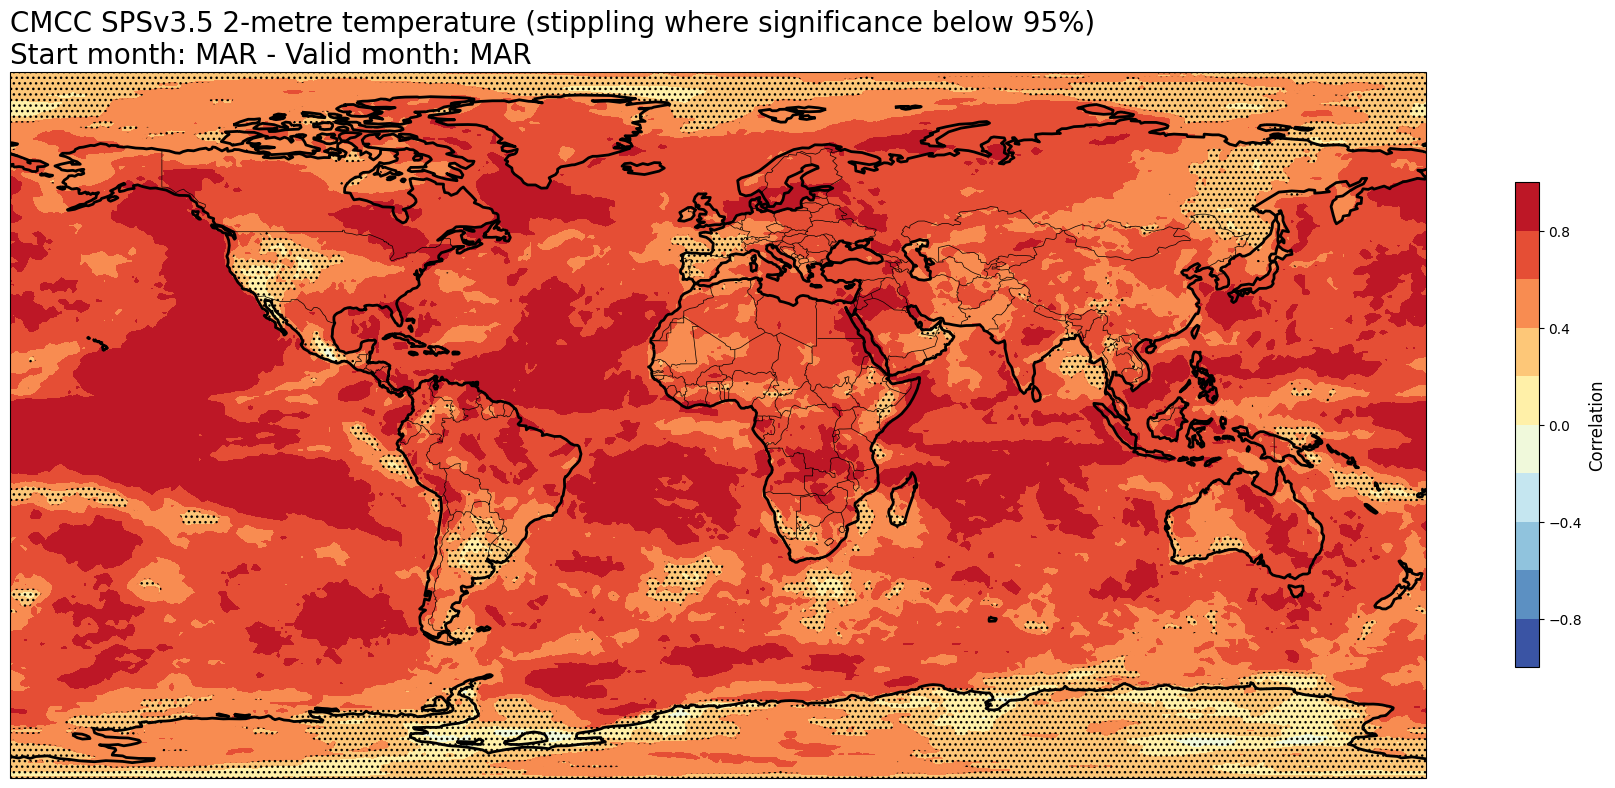

In [17]:
# Read the data files
corr = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr.nc')
corr_pval = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr_pval.nc')
# RE-ARRANGE the DATASETS longitude values for plotting purposes
corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')
corr_pval = corr_pval.assign_coords(lon=(((corr_pval.lon + 180) % 360) - 180)).sortby('lon')


thiscorr = corr.sel(forecastMonth=fcmonth)
thiscorrpval = corr_pval.sel(forecastMonth=fcmonth)

for var in thiscorr.data_vars:
    fig = plt.figure(figsize=(18,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    corrvalues = thiscorr[var].values 
    corrpvalvalues = thiscorrpval[var].values

    if corrvalues.T.shape == (thiscorr[var].lat.size, thiscorr[var].lon.size):
        print('Data values matrices need to be transposed')
        corrvalues = corrvalues.T
        corrpvalvalues = corrpvalvalues.T
    elif corrvalues.shape == (thiscorr[var].lat.size, thiscorr[var].lon.size):
        pass                           
        # print('Data values matrices shapes are ok')
    else:
        raise BaseException(f'Unexpected data value matrix shape: {corrvalues.shape}' )


    plt.contourf(thiscorr[var].lon,thiscorr[var].lat,corrvalues,levels=np.linspace(-1.,1.,11),cmap='RdYlBu_r')
    cb = plt.colorbar(shrink=0.5)
    cb.ax.set_ylabel('Correlation',fontsize=12)
    origylim = ax.get_ylim()
    plt.contourf(thiscorrpval[var].lon,thiscorrpval[var].lat,corrpvalvalues,levels=[0.05,np.inf],hatches=['...',None],colors='none')
    # We need to ensure after running plt.contourf() the ylim hasn't changed
    if ax.get_ylim()!=origylim:
        ax.set_ylim(origylim)

    plt.title(tit_line1 + f' {VARNAMES[var]}' +' (stippling where significance below 95%)\n' + tit_line2,loc='left')

    
    plt.tight_layout()
    figname = f'{DATADIR}/plots/stmonth{config["start_month"]:02d}/{hcst_bname}.{aggr}.fcmonth{fcmonth}.{var}.corr.png'
    plt.savefig(figname)

<hr>

### 5.B. Ranked Probability Score (RPS)

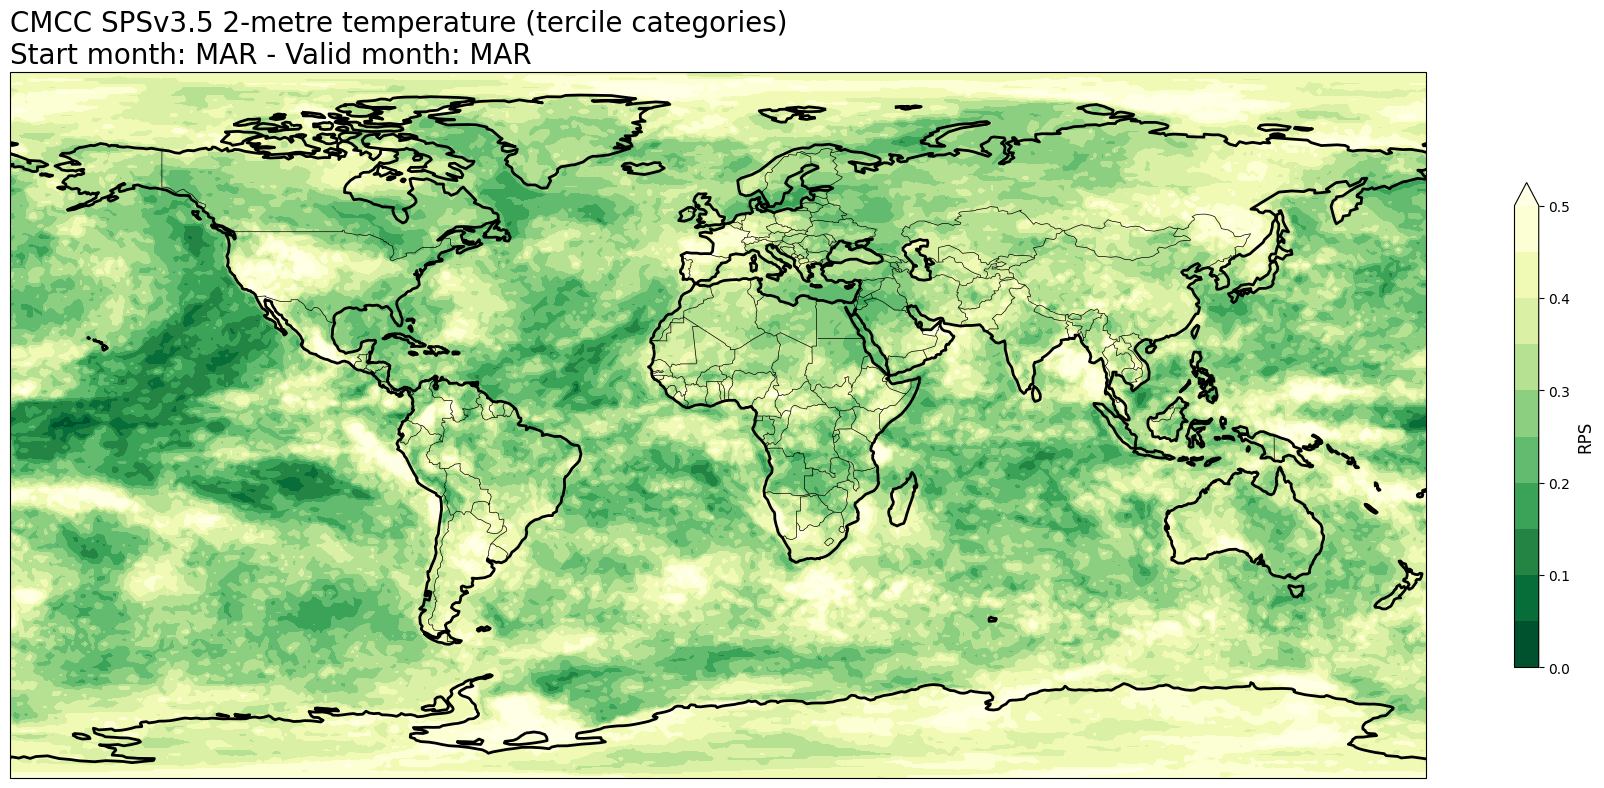

In [18]:
# READ scores xr.Datasets
rps = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rps.nc')
# RE-ARRANGE the DATASETS longitude values for plotting purposes
rps = rps.assign_coords(lon=(((rps.lon + 180) % 360) - 180)).sortby('lon')

thisrps = rps.sel(forecastMonth=fcmonth)

for var in thisrps.data_vars:
    fig = plt.figure(figsize=(18,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    avalues = thisrps[var].values
    cs = plt.contourf(thisrps[var].lon,thisrps[var].lat,avalues,levels=np.linspace(0.,0.5,11),cmap='YlGn_r', extend='max')
    cs.cmap.set_under('purple')
    cb = plt.colorbar(shrink=0.5)
    cb.ax.set_ylabel('RPS',fontsize=12)
    plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2,loc='left')
    plt.tight_layout()  
    figname = f'{DATADIR}/plots/stmonth{config["start_month"]:02d}/{hcst_bname}.{aggr}.fcmonth{fcmonth}.{var}.rps.png'
    plt.savefig(figname)  


<hr>

### 5.C. Area under Relative Operating Characteristic (ROC) curve

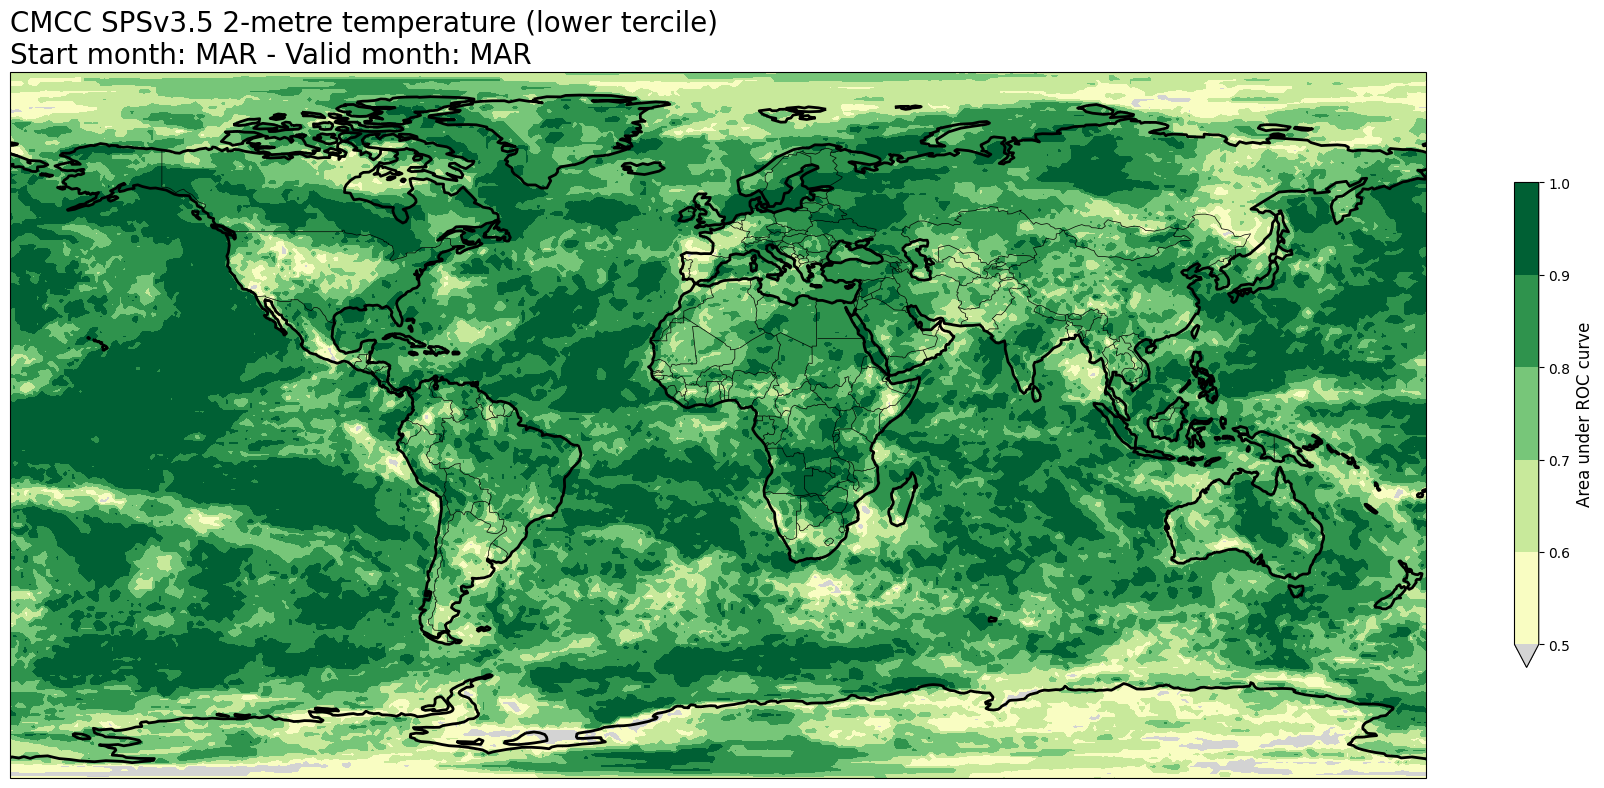

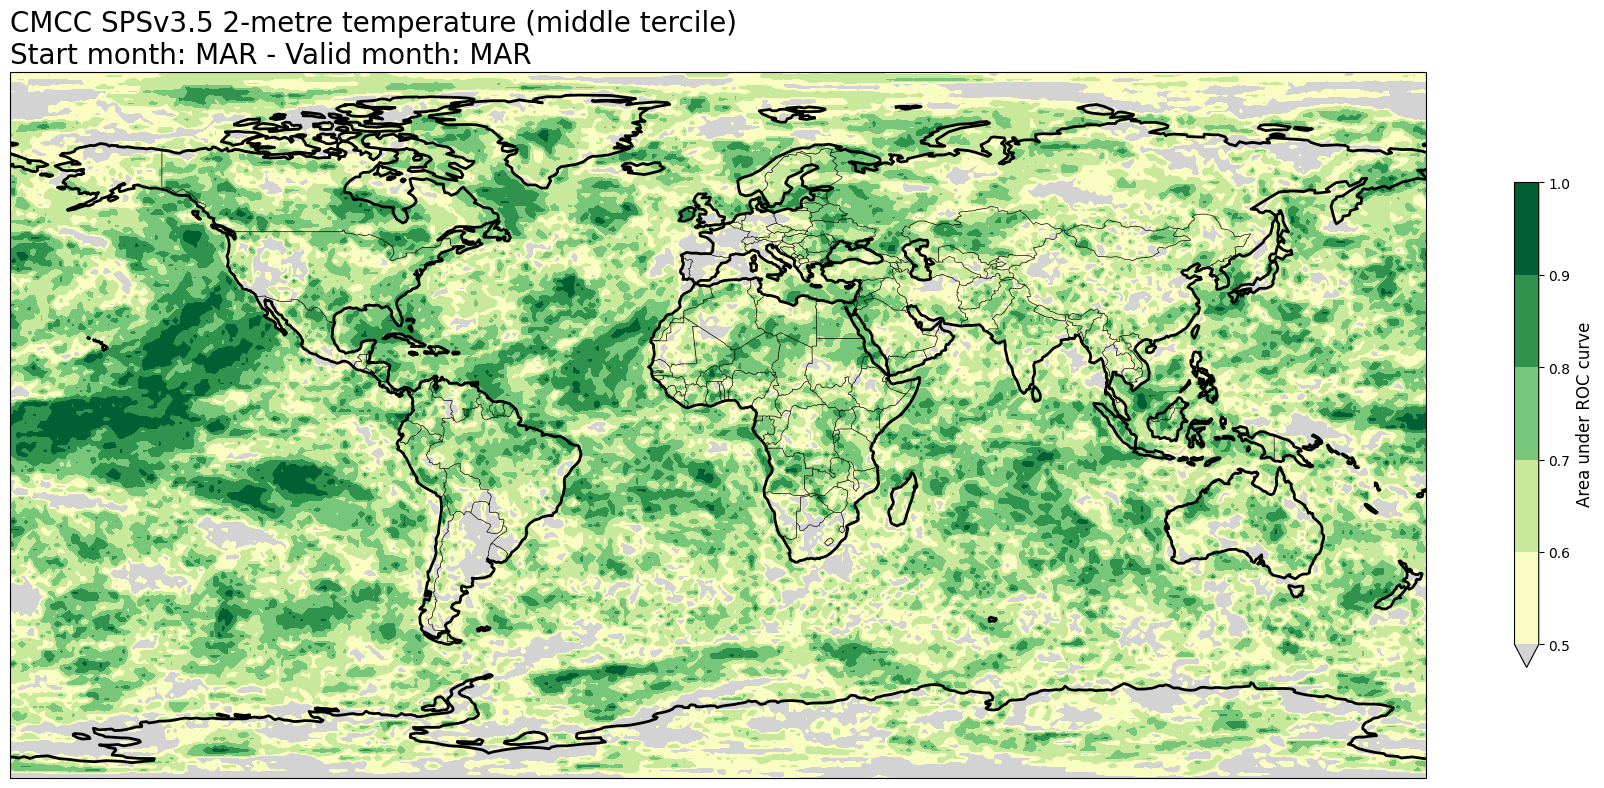

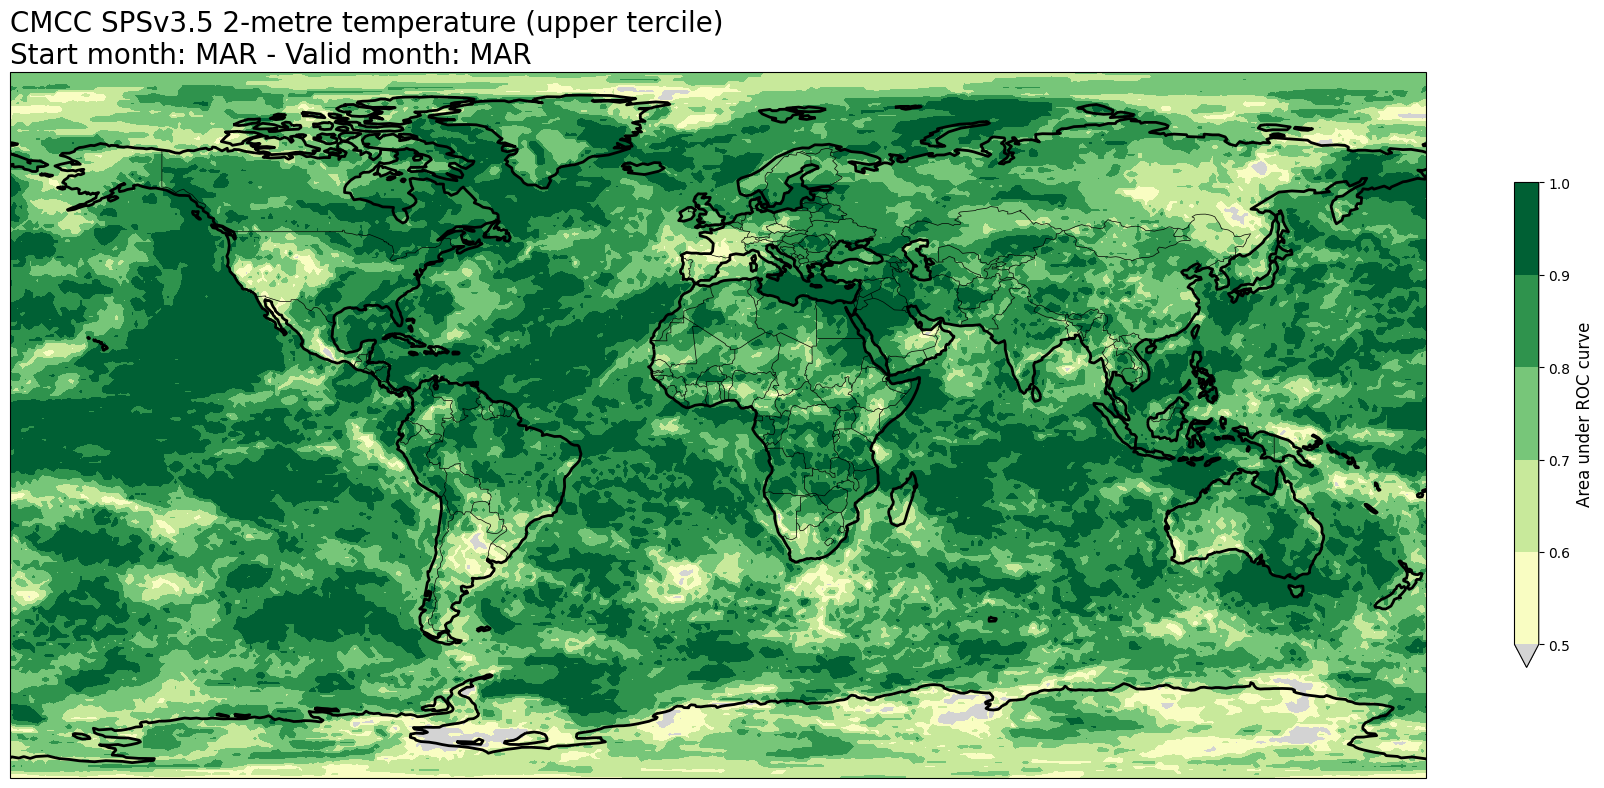

In [19]:
# READ scores xr.Datasets
roc = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.roc.nc')
# RE-ARRANGE the DATASETS longitude values for plotting purposes
roc = roc.assign_coords(lon=(((roc.lon + 180) % 360) - 180)).sortby('lon')

thisroc = roc.sel(forecastMonth=fcmonth)

for var in thisroc.data_vars:
    for icat in thisroc.category.values:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisroc.sel(category=icat)[var].values
        cs = plt.contourf(thisroc[var].lon,thisroc[var].lat,avalues,levels=np.linspace(0.5,1.,6),cmap='YlGn', extend='min')
        cs.cmap.set_under('lightgray')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel('Area under ROC curve',fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')
        plt.tight_layout()  
        figname = f'{DATADIR}/plots/stmonth{config["start_month"]:02d}/{hcst_bname}.{aggr}.fcmonth{fcmonth}.{var}.category{icat}.roc.png'
        plt.savefig(figname)  

<hr>

## Key Messages to Take Home 📌
 
- Seasonal forecast anomalies are defined as the difference of a given hindcast to the model climate, computed as the average over all the available members.

- Probabilities for tercile categories are defined as the proportion of members in a given hindcast lying within each one of the categories bounded by the terciles computed from all available members in the reference period.

- Specific verification metrics and scores are to be computed for both deterministic (anomalies) and probabilistic (probabilities of tercile categories).

- All computed metrics and scores must be spatially visualized.

- Information on how these metrics and scores work as indicators of 'confidence' of the real-time forecast can be found in the "Introduction" section of the <a href="https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots">C3S seasonal forecasts verification plots</a> page on the Copernicus Knowledge Base.

<hr>